<a href="https://colab.research.google.com/github/mykolesiko/advanced_RL/blob/master/gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
os.chdir("/content/drive/MyDrive/MADE/semester3/Advanced_RL")
from pathlib import Path
import random

import numpy as np
import time
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from tqdm.notebook import trange, tqdm

from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2
import dataset
from dataset import *
import model
from model import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Часть первая: перенос стиля при помощи pix2pix
В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data). Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов:

Датасет можно скачать здесь (и во многих других местах, должно быть ~29 мегабайт).
В первой части подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля (подробнее см. лекцию и собственно Isola et al., 2016):   
https://arxiv.org/pdf/1611.07004.pdf


## Скачивам датасеты

In [ ]:
#!curl  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz --output facades.tar.gz
#os.makedirs('data', exist_ok=True)


In [ ]:
#!unzip -q ./facades.tar.gz  

## Датасет

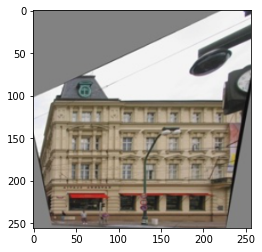

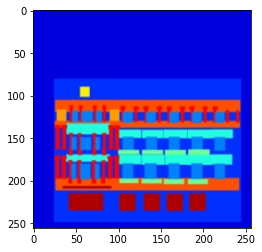

In [6]:
dataset = Dataset(datapath='./facades/train', split = 'train')
(image, mask) = dataset.__getitem__(20)
im = transforms.ToPILImage()(image).convert("RGB")
plt.imshow(im)
plt.show()

im = transforms.ToPILImage()(mask).convert("RGB")
plt.imshow(im)
plt.show()

In [9]:
Gen = Generator()
Discr = Discriminator()
Gen.train()
Discr.train()
x = torch.ones((2, 3, 256, 256))
mask = torch.ones((2, 3, 256, 256))
print(Gen(mask).shape)
print(Discr(x, mask).shape)

torch.Size([2, 3, 256, 256])
torch.Size([2, 1, 30, 30])


In [10]:
batch_size = 16
train_dataset = Dataset('./facades/train', split  = 'train')
test_dataset = Dataset('./facades/val', split = 'val')
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

lr, beta1, beta2, l1_lambda = 0.0002, 0.5, 0.999, 100
optimizer_G = torch.optim.Adam(Gen.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(Discr.parameters(), lr=lr, betas=(beta1, beta2))

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
Gen.to(device)
Discr.to(device)
print(device)

cuda


In [23]:
lr, beta1, beta2, l1_lambda = 0.000002, 0.5, 0.999, 100

In [ ]:
num_epochs = 200

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}')
    time.sleep(0.5)
    d_losses = []
    g_losses = []
    Gen.train()
    Discr.train()
    for batch in tqdm(train_dataloader):
        images, masks = batch
        #print(images.shape)
        images = images.to(device)
        masks = masks.to(device)
        
        #valid = Variable(torch.Tensor(images.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        #fake = Variable(torch.Tensor(images.size(0), 1).fill_(0.0), requires_grad=False).to(device)
        

        # Generator loss
        optimizer_G.zero_grad()
        generated = Gen(masks)
        disc_generated = Discr(generated, masks)
        valid = Variable(torch.ones((images.size(0), 1, 30, 30)), requires_grad=False).to(device)
        fake = Variable(torch.zeros((images.size(0), 1, 30, 30)), requires_grad=False).to(device)
        
        g_loss = F.binary_cross_entropy(disc_generated, valid) + l1_lambda * F.l1_loss(generated, images)
        g_loss.backward()
        optimizer_G.step()

        # Dicriminator loss
        optimizer_D.zero_grad()
        # Функции потерь на настоящих и фейковых картинках
        real_loss = F.binary_cross_entropy(Discr(images, masks), valid)
        fake_loss = F.binary_cross_entropy(Discr(generated.detach(), masks), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
    print(f'g_loss: {np.mean(g_losses)} d_loss: {np.mean(d_losses)}')
    if (epoch + 1) % 10 == 0:
        Gen.eval()
        plot_images(images, masks, generated.detach())

In [25]:
torch.save(Gen.state_dict(), 'G3.pth')
torch.save(Discr.state_dict(), 'D3.pth')

In [26]:
Gen.load_state_dict(torch.load('G3.pth'))
Discr.load_state_dict(torch.load('D3.pth'))

<All keys matched successfully>

In [ ]:
test_dataset1 = Dataset('./facades/test', split = 'test')
test_dataloader1 = data.DataLoader(test_dataset1, batch_size=4, shuffle=True, num_workers=2)
dataiter = iter(test_dataloader1)
Gen.eval()


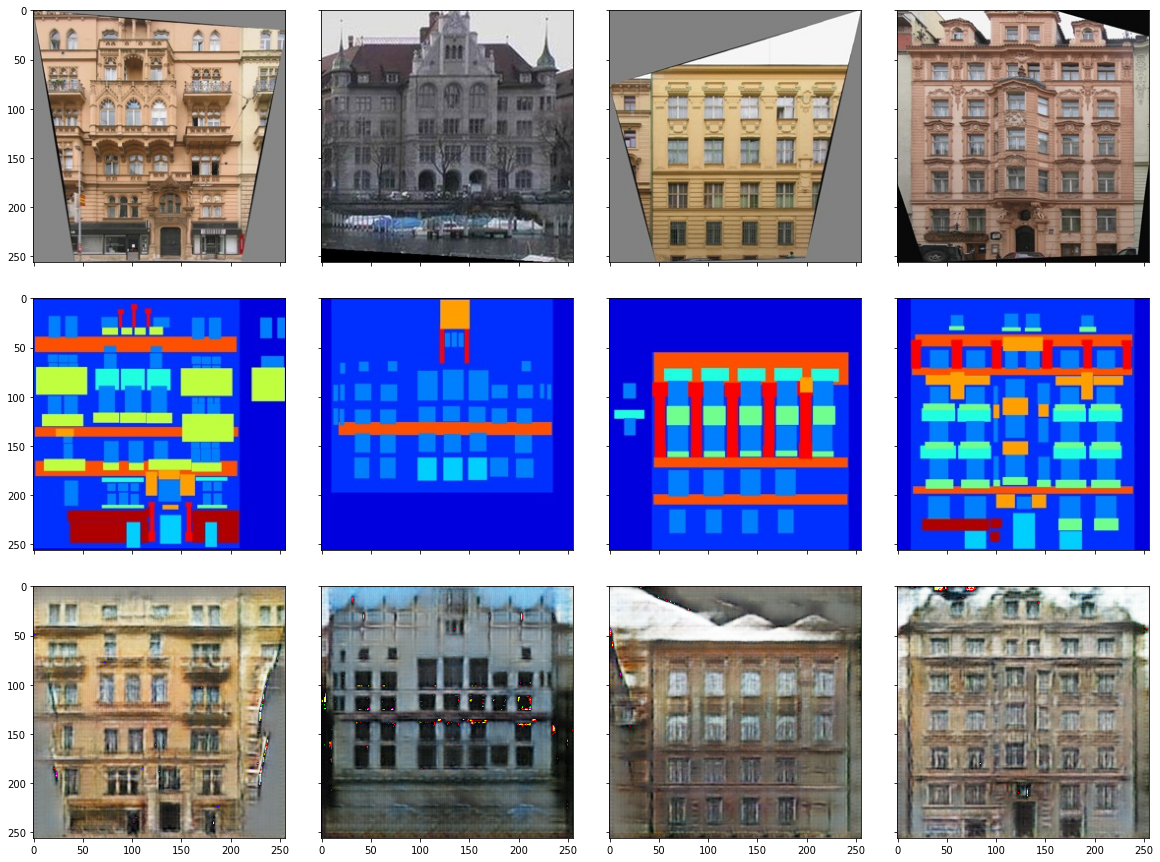

In [28]:
batch = next(dataiter)
images, masks = batch
images = images.to(device)
masks = masks.to(device)
with torch.no_grad():
    generated = Gen(masks)

plot_images(images, masks, generated)

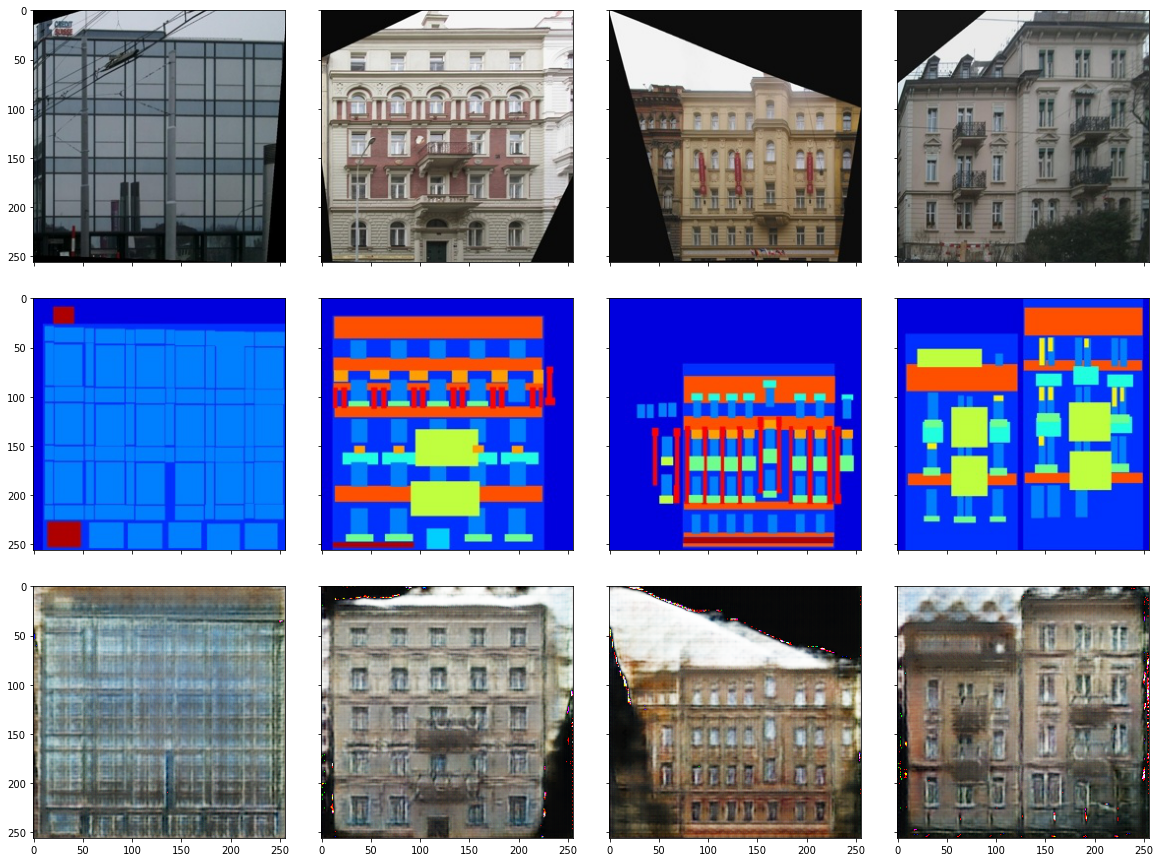

In [29]:
batch = next(dataiter)
images, masks = batch
images = images.to(device)
masks = masks.to(device)
with torch.no_grad():
    generated = Gen(masks)

plot_images(images, masks, generated)

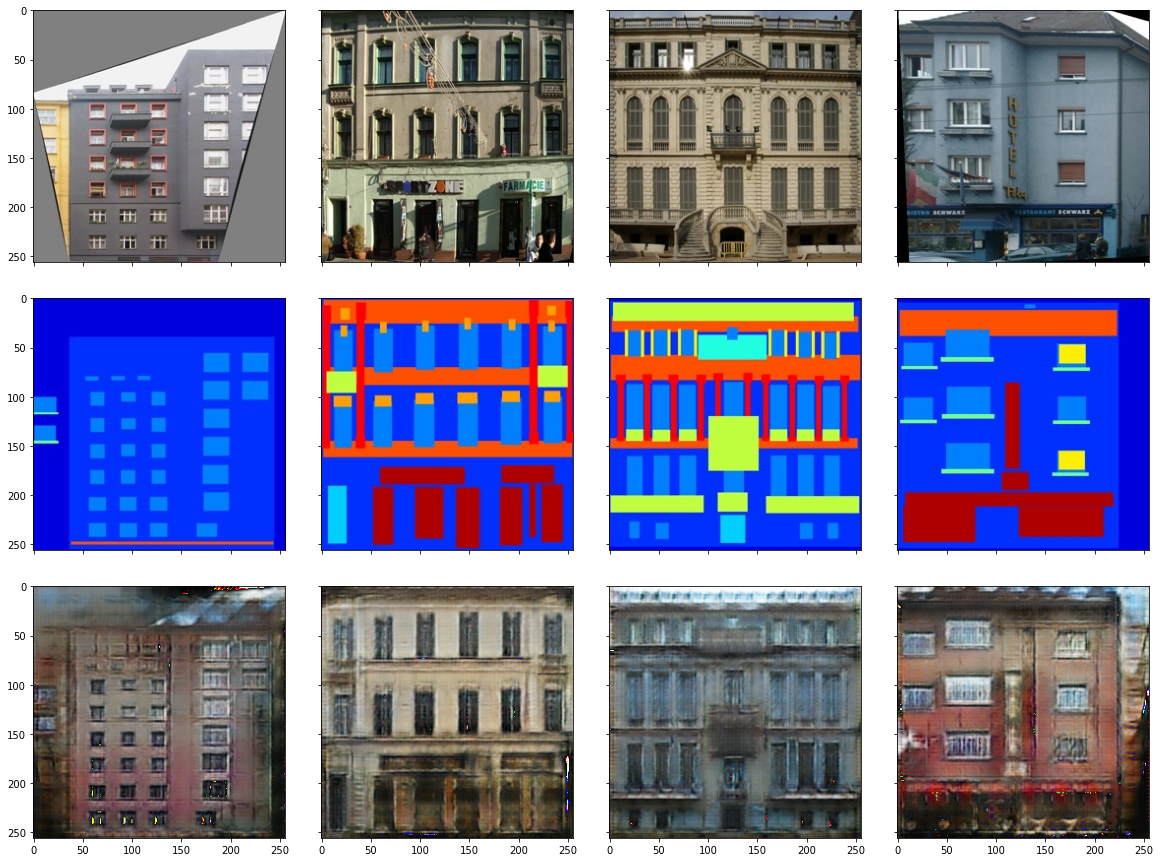

In [30]:
batch = next(dataiter)
images, masks = batch
images = images.to(device)
masks = masks.to(device)
with torch.no_grad():
    generated = Gen(masks)

plot_images(images, masks, generated)